In [15]:
import xarray as xr
import raster_to_features as rm
import os
import rioxarray as rioxr

from shapely.geometry import Polygon

from joblib import load
import time
import pandas as pd
import numpy as np
import rasterio

import matplotlib.pyplot as plt

In [2]:
from scipy.ndimage import generic_filter
from scipy import stats

In [3]:
def classify_iceplant(raster, rfc):
    rm.raster_as_df(raster.to_numpy(), ['r','g','b','nir'])

    # find vegetation pixels to go into model
    # keep ndices of water and low-ndvi pixels
    # adds ndvi and ndwi features for each pixel
    is_veg, water_index, not_veg_index = rm.add_spectral_features(df = rm.raster_as_df(raster.to_numpy(), 
                                                                                       ['r','g','b','nir']), #names of bands
                                                               ndwi_thresh = 0.3, 
                                                               ndvi_thresh = 0.05) 
    # select features
    is_veg.drop('ndwi', axis=1, inplace=True)
    is_veg = rm.add_date_features(is_veg, raster.datetime)
    # ---------------------------------------
    # predict using model

    preds = rfc.predict(is_veg.to_numpy())    
    t0 = time.time()
    print('finished predicting\n   time taken to predict: ', time.time() - t0,' s')

    # ---------------------------------------
    # recover pixel indices for iceplant classifications
    preds_df = pd.DataFrame(preds, 
                         columns=['is_iceplant'], 
                         index = is_veg.index)
    is_iceplant_index = preds_df[preds_df.is_iceplant == 1].index.to_numpy()
    non_iceplant_index = preds_df[preds_df.is_iceplant == 0].index.to_numpy()

    # ---------------------------------------
    # reconstruct indices into image
    indices = [non_iceplant_index,
               is_iceplant_index, 
               not_veg_index,
               water_index]
    values = [0,    # values assigned to pixels from each index
              1,
              2,
              3]
    t0 = time.time()
    reconstruct = rm.indices_to_image(raster.shape[1], raster.shape[2], indices, values, back_value=100)
    print('reconstructed image\n   time taken to reconstruct: ', time.time() - t0,' s')
    
    return reconstruct

In [6]:
# ---------------------------------------
# save raster 

def save_raster(filename, raster):
    with rasterio.open(
        os.path.join(os.getcwd(),'temp','dangermond',filename),  # file path
        'w',           # w = write
        driver = 'GTiff', # format
        height = raster.shape[0], 
        width = raster.shape[1],
        count = 1,  # number of raster bands in the dataset
        dtype = rasterio.uint8,
        crs = raster.rio.crs,
        transform = raster.rio.transform(),
    ) as dst:
        dst.write(raster.astype(rasterio.uint8), 1)
    return 

# ---------------------------------------
# https://stackoverflow.com/questions/54439298/image-filter-which-uses-the-highest-occurence-of-pixel-values
# Modal filter
def modal(P):
    """We receive P[0]..P[8] with the pixels in the 3x3 surrounding window"""
    mode = stats.mode(P)
    return mode.mode[0]

In [7]:
# open pre-trained random forest classifier
rfc = load('spectral_rfc.joblib') 
print('loaded model')

loaded model


In [8]:
reduce_box = Polygon([[-120.4629726682,34.4571320535],
                      [-120.4584485416,34.4571320535],
                      [-120.4584485416,34.4592144415],
                      [-120.4629726682,34.4592144415],
                      [-120.4629726682,34.4571320535]])

In [9]:
itemid = 'ca_m_3412037_nw_10_060_20200607'  # dgr 2020
#itemid = 'ca_m_3412037_nw_10_1_20120518_20120730' # dgr 2012
r_20 = rm.rioxr_from_itemid(itemid, 
                    reduce_box,
                    "EPSG:4326")
fn_20 = 'box_2020_dangermond.tif'
r_20

<xarray.DataArray (band: 4, y: 403, x: 704)>
[1134848 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 7.33e+05 7.33e+05 7.33e+05 ... 7.335e+05 7.335e+05
  * y            (y) float64 3.816e+06 3.816e+06 ... 3.816e+06 3.816e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    _FillValue:    0
    datetime:      2020-06-07 00:00:00+00:00

In [10]:
itemid = 'ca_m_3412037_nw_10_1_20120518_20120730' # dgr 2012
r_12 = rm.rioxr_from_itemid(itemid, 
                    reduce_box,
                    "EPSG:4326")
fn_20 = 'box_2012_dangermond.tif'
r_12

<xarray.DataArray (band: 4, y: 242, x: 423)>
[409464 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 7.33e+05 7.33e+05 7.331e+05 ... 7.335e+05 7.335e+05
  * y            (y) float64 3.816e+06 3.816e+06 ... 3.816e+06 3.816e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    datetime:      2012-05-18 00:00:00+00:00

In [13]:
preds_20 = classify_iceplant(r_20,rfc)
preds_12 = classify_iceplant(r_12,rfc)

finished predicting
   time taken to predict:  1.430511474609375e-06  s
reconstructed image
   time taken to reconstruct:  0.007140636444091797  s
finished predicting
   time taken to predict:  9.5367431640625e-07  s
reconstructed image
   time taken to reconstruct:  0.002558469772338867  s


In [14]:
filter20 = generic_filter(preds_20, modal, (3, 3))
filter12 = generic_filter(preds_12, modal, (3, 3))

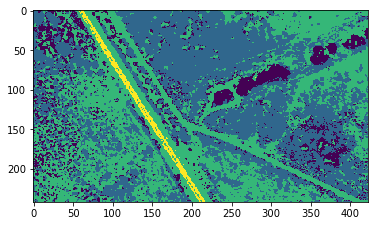

In [16]:
plt.imshow(preds_12, interpolation='none')
plt.show()

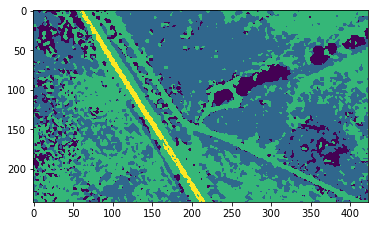

In [17]:
plt.imshow(filter12, interpolation='none')
plt.show()

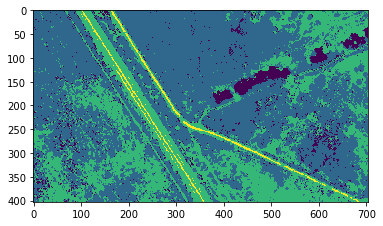

In [18]:
plt.imshow(preds_20, interpolation='none')
plt.show()

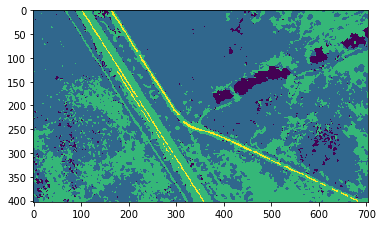

In [19]:
plt.imshow(filter20, interpolation='none')
plt.show()